# Content-based Recommendation Baseline

Inspired by [Deep content-based music recommendation](https://papers.nips.cc/paper/5004-deep-content-based-music-recommendation.pdf) by van den Oord, Dieleman 

Instead of using MFCC, which would require extraction, we use the timbre features which are already provided by the EchoNest API. Code here is taken from/based on the source for the [Notebooks](https://github.com/dawenl/stochastic_PMF) for [Codebook-based Scalable Music Tagging with Poisson Matrix Factorization](http://dawenl.github.io/publications/LiangPE14-codebook.pdf) by Dawen Liang, John Paisley and Dan Ellis, in ISMIR 2014, with modifications.

In [8]:
import json
import math
import numpy as np
import pickle
import os
from constants import SubsetDataset
from lib import hdf5_getters
from lib.hartigan import HartiganOnline
from lib.quantize import VectorQuantizer
from matplotlib import pyplot as plt

In [2]:
def get_all_unique_tracks(ConstantClass, cache_dir=os.path.join(".", "data", "cache")):
    tracks = set()
    cache_path = os.path.join(cache_dir, "tracks.json")

    if os.path.exists(cache_path):
        with open(cache_path, "r") as f:
            return json.load(f)

    with open(ConstantClass.MSD_UNIQ_TRACKS_PATH, 'rb') as f:
        for (count, line) in enumerate(f):
            track_id, _, _, _ = line.decode("utf-8").strip().split("<SEP>")
            tracks.add(track_id)
            if count % 1000 == 0:
                print(f"{count} tracks processed")

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    tracks = list(tracks)
    with open(cache_path, "w") as f:
        json.dump(tracks, f)
    
    return tracks

In [3]:
uniq_tracks = get_all_unique_tracks(SubsetDataset)

## Vector Quantization

VQ allows us to get a feature representation.

In [4]:
def data_generator(ConstantClass, tracks, shuffle=True, ext=".h5"):
    if shuffle:
        np.random.shuffle(list(tracks))

    for track_id in tracks:
        track_dir = os.path.join(ConstantClass.MSD_DATA_DIR, '/'.join(track_id[2:5]), track_id + ext)
        h5 = hdf5_getters.open_h5_file_read(track_dir)
        timbre = hdf5_getters.get_segments_timbre(h5)
        h5.close()
        if shuffle:
            np.random.shuffle(timbre)
        yield timbre
 

def build_codewords(ConstantClass, tracks,  n_clusters=2, max_iter=10, random_state=None, cluster=None):
    if type(random_state) is int:
        np.random.seed(random_state)
    elif random_state is not None:
        np.random.set_state(random_state)
 
    if cluster is None:
        cluster = HartiganOnline(n_clusters)

    for i in range(max_iter):
        print(f"Iteration {i+1}: Passing through the data...")
        for d in data_generator(ConstantClass, tracks):
            cluster.partial_fit(d)

    return cluster

In [5]:
def get_codewords(ConstantClass, tracks, n_clusters, max_iter, random_state, cache_dir=os.path.join(".", "data", "cache")):
    cache_path = os.path.join(cache_dir, "cluster.pkl")
    
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            cluster = pickle.load(f)
            return cluster

    cluster = build_codewords(ConstantClass, tracks, n_clusters, max_iter, random_state)
    
    with open(cache_path, "wb") as f:
        pickle.dump(cluster, f)
    
    return cluster

Iteration 1: Passing through the data...
Iteration 2: Passing through the data...
Iteration 3: Passing through the data...


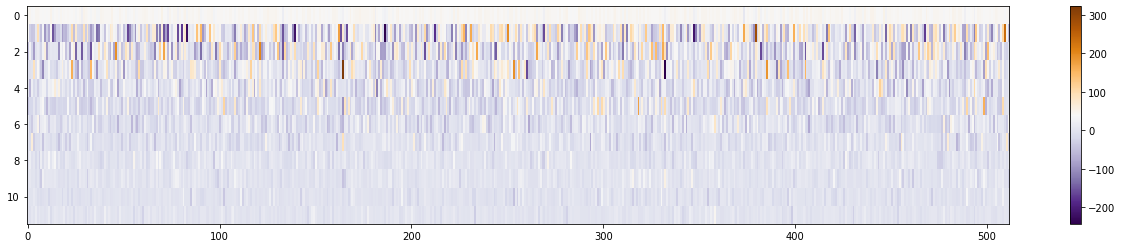

In [6]:
K = 512
codebook = get_codewords(SubsetDataset, uniq_tracks, n_clusters=K, max_iter=3, random_state=98765)
plt.figure(figsize=(22, 4))
plt.imshow(codebook.cluster_centers_.T, cmap="PuOr_r", aspect="auto", interpolation="nearest")
plt.colorbar()

In [10]:
vq = VectorQuantizer(clusterer=codebook)
vq.center_norms_ = 0.5 * (vq.clusterer.cluster_centers_ ** 2).sum(axis=1)
vq.components_ = vq.clusterer.cluster_centers_

def quantize_and_save(vq, K, msd_data_root, track_id):
    track_dir = os.path.join(msd_data_root, '/'.join(track_id[2:5]), track_id + ".h5")
    h5 = hdf5_getters.open_h5_file_read(track_dir)
    timbre = hdf5_getters.get_segments_timbre(h5)
    h5.close()
    
    hist_dir = os.path.join("data", "vq_hist", "/".join(track_id[2:5]))
    if not os.path.exists(hist_dir):
        os.makedirs(hist_dir)
    
    vq_path = os.path.join(hist_dir, track_id + '_K%d' % K)
    if os.path.exists(os.path.join(vq_path) + '.npy'):
        return

    vq_hist = vq.transform(timbre).sum(axis=0).astype(np.int16)
    np.save(os.path.join(hist_dir, track_id + '_K%d' % K), vq_hist)

for track_id in uniq_tracks:
    quantize_and_save(vq, K, SubsetDataset.MSD_DATA_DIR, track_id) 